# Read data

In [1]:
import pandas as pd

#Read sentences from a text file
def read_file(filename):
    with open(filename, 'r') as f:
        lines = [x.strip() for x in f.readlines()]
        return lines

sentences = read_file("data/snips_sentences_subset.txt")
slot_labels = read_file("data/snips_slot_labels_subset.txt")

df = pd.DataFrame(list(zip(sentences, slot_labels)), columns =['sentences', 'slot_labels']) 
df.head()

,sentences,slot_labels
0,Add another song to the Cita RomÃ¡ntica playlist,O O B-music_item O O B-playlist I-playlist O
1,add clem burke in my playlist Pre-Party R&B Jams,O B-artist I-artist O B-playlist_owner O B-pla...
2,Add Live from Aragon Ballroom to Trapeo,O B-entity_name I-entity_name I-entity_name I-...
3,add Unite and Win to my night out,O B-entity_name I-entity_name I-entity_name O ...
4,Add track to my Digster Future Hits,O B-music_item O B-playlist_owner B-playlist I...


# Data Preparation

In [2]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

TEST_SPLIT = 0.2
RANDOM_STATE = 1
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

#Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(df['sentences'], df['slot_labels'], 
                                                    test_size = TEST_SPLIT, random_state = RANDOM_STATE)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6299,) (1575,) (6299,) (1575,)


In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils

NUM_WORDS = 7501
OOV_TOKEN = "<UNK>"

#Initialize Tokenizers
tokenizer = Tokenizer(num_words = NUM_WORDS, filters = '', lower = False, split = ' ', oov_token = OOV_TOKEN)
tokenizer.fit_on_texts(list(X_train))

y_tokenizer = Tokenizer(filters = '', lower = False, split = ' ')
y_tokenizer.fit_on_texts(list(y_train))

#Convert text to sequences
X_seq = tokenizer.texts_to_sequences(list(X_train))
X_test_seq = tokenizer.texts_to_sequences(list(X_test))

y_seq = y_tokenizer.texts_to_sequences(list(y_train))
y_test_seq = y_tokenizer.texts_to_sequences(list(y_test))

MAX_SEQ_LEN = 35

#Pad the sequences
X_train_padded = pad_sequences(X_seq, maxlen = MAX_SEQ_LEN, padding = 'post')
X_test_padded = pad_sequences(X_test_seq, maxlen = MAX_SEQ_LEN, padding = 'post')

y_train_padded = pad_sequences(y_seq, maxlen = MAX_SEQ_LEN, padding = 'post')
y_test_padded = pad_sequences(y_test_seq, maxlen = MAX_SEQ_LEN, padding = 'post')

#Convert labels to one-hot vectors
y_train_encoded = utils.to_categorical(y_train_padded)
y_test_encoded = utils.to_categorical(y_test_padded)
print(y_train_encoded.shape, y_test_encoded.shape)

#Reshape the input for Bi-LSTM
X_train_padded = np.reshape(X_train_padded, (X_train_padded.shape[0], X_train_padded.shape[1], 1))
X_test_padded = np.reshape(X_test_padded, (X_test_padded.shape[0], X_test_padded.shape[1], 1))
print(X_test_padded.shape, X_test_padded.shape)

(6299, 35, 58) (1575, 35, 58)
(1575, 35, 1) (1575, 35, 1)


# Model Training

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, TimeDistributed
from tensorflow.keras.metrics import Precision, Recall

VAL_SPLIT = 0.1
BATCH_SIZE = 32
EPOCHS = 7
EMBEDDING_DIM = 64
NUM_UNITS = 32
VOCAB_SIZE = NUM_WORDS
Y_VOCAB_SIZE = len(y_tokenizer.word_index) + 1


#Define a Bi-LSTM model
bilstm_model = Sequential()
bilstm_model.add(Embedding(input_dim = VOCAB_SIZE, output_dim = EMBEDDING_DIM, input_length = MAX_SEQ_LEN))
bilstm_model.add(Bidirectional(LSTM(NUM_UNITS, activation='relu', return_sequences=True)))
bilstm_model.add(TimeDistributed(Dense(Y_VOCAB_SIZE, activation='softmax')))

#Compile the model
bilstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[Precision(), Recall(), 'accuracy'])

bilstm_model.summary()

#Fit the model on training data
bilstm_history = bilstm_model.fit(X_train_padded, y_train_encoded, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_split = VAL_SPLIT)


2022-01-14 13:58:53.155569: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 64)            480064    
                                                                 
 bidirectional (Bidirectiona  (None, 35, 64)           24832     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 35, 58)           3770      
 ibuted)                                                         
                                                                 
Total params: 508,666
Trainable params: 508,666
Non-trainable params: 0
_________________________________________________________________
Epoch 1/7
178/178 [==============================] - 6s 23ms/step - loss: 1.3057 - precision: 0.9592 - recall: 0.6252 - accuracy: 0.8311 - val_loss: 0.6387 - val_precision: 0.9678 - 

## Plot Learning Curves

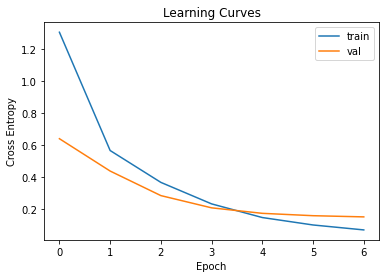

In [5]:
from matplotlib import pyplot

# plot learning curves
pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cross Entropy')
pyplot.plot(bilstm_history.history['loss'], label='train')
pyplot.plot(bilstm_history.history['val_loss'], label='val')
pyplot.legend()
pyplot.savefig("learning_curve.jpg", bbox_inches='tight', dpi = 300)
pyplot.show()

# Evaluation

In [6]:
#Evaluate the model performance on test data
bilstm_score = bilstm_model.evaluate(X_test_padded, y_test_encoded, batch_size = BATCH_SIZE)

50/50 [==============================] - 0s 6ms/step - loss: 0.1515 - precision: 0.9787 - recall: 0.9531 - accuracy: 0.9624


# Prediction

In [7]:
label_list = list(y_tokenizer.word_index.keys())
index_list = list(y_tokenizer.word_index.values())

#Input sentence
sentence = "I want to watch The Matrix"
input_seq = tokenizer.texts_to_sequences([sentence])
input_features = pad_sequences(input_seq, maxlen = MAX_SEQ_LEN, padding = 'post')

#Predict the slots
prediction = bilstm_model.predict(input_features)
slots = [label_list[index_list.index(j)] for j in [np.argmax(x) for x in prediction[0][:]] if j in index_list]
print(sentence)
print(slots)

I want to watch The Matrix
['O', 'O', 'O', 'O', 'B-movie_name', 'I-movie_name']
